<a href="https://colab.research.google.com/github/javier-jaime/Stock_Price_Forecasting/blob/main/LSPD_Price_Forecasting_with_yfinance_and_Facebook_Prophet_June_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Price Forecasting with yfinance and Facebook Prophet**

## Importing all the necessary Libraries

In [37]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
from fbprophet import Prophet
import plotly.io as pio
pio.renderers.default='colab'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing the Dataset & Exploring it

In [55]:
# Stock Ticker Input
stock = input('Enter the stock ticker: ')
print(f'You entered {stock}, here is the data from the last 10 days:')
period = '2y'
ticker = yf.Ticker(stock)
data = ticker.history(period)
data.reset_index(inplace=True)
data.tail(10)

Enter the stock ticker: LSPD.TO
You entered LSPD.TO, here is the data from the last 10 days:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
493,2022-05-19,27.629999,29.670000,25.650000,28.650000,2489000,0,0
494,2022-05-20,29.540001,30.299999,28.020000,29.510000,2457600,0,0
495,2022-05-24,30.000000,30.299999,27.049999,27.549999,1994700,0,0
496,2022-05-25,27.270000,28.809999,27.200001,28.770000,1735600,0,0
497,2022-05-26,28.850000,32.320000,28.250000,31.850000,2265600,0,0
498,2022-05-27,32.500000,33.400002,31.980000,32.959999,2202200,0,0
499,2022-05-30,33.500000,35.799999,33.445000,34.250000,1671300,0,0
500,2022-05-31,33.750000,34.000000,32.330002,32.889999,3497300,0,0
501,2022-06-01,33.430000,34.029999,30.860001,31.680000,1589100,0,0
502,2022-06-02,31.420000,34.009998,31.320000,33.970001,598664,0,0


In [56]:
print('These are the basic stats:')
data.describe()

These are the basic stats:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,503.000000,503.000000,503.000000,503.000000,5.030000e+02,503.0,503.0
mean,69.031312,70.717565,67.164016,68.960775,8.704097e+05,0.0,0.0
std,33.590065,34.194976,33.045165,33.673050,5.858834e+05,0.0,0.0
min,20.090000,22.180000,19.580000,20.520000,1.353000e+05,0.0,0.0
25%,39.135000,40.125000,38.010000,39.170000,4.985500e+05,0.0,0.0
50%,67.849998,71.160004,65.540001,67.669998,7.100000e+05,0.0,0.0
75%,90.085003,91.960003,87.825001,90.174999,1.074400e+06,0.0,0.0
max,160.940002,165.869995,157.130005,158.929993,6.905100e+06,0.0,0.0


# Data Visualization (plotly express) - Visualizing the historical performance

In [57]:
#Line graph (Price), Area graph (Volume) , box plot (Analyzing price and volume)

In [58]:
px.line(data, x="Date", y="Close", title=f'{stock} Stock Close Price')

In [59]:
px.bar(data, x="Date", y="Volume", title=f'{stock} Stock Volume')

In [60]:
px.box(data, y="Close", title=f'{stock} box plot', height=500, width=500)

In [61]:
def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [62]:
hurst = pd.DataFrame(columns =["hurst_exp","lag"])
lags = range(4, 121, 2)
for lag in lags:
    hurst_exp = get_hurst_exponent(data["Close"].values, lag)
    hurst = hurst.append({"hurst_exp":hurst_exp,"lag":lag},ignore_index=True)
px.line(hurst, x="hurst_exp", y="lag", title=f'{stock} Hurst Exp')

## Data Preparation for Facebook Prophet

In [63]:
columns=['Date','Close']
prophet_df=pd.DataFrame(data,columns=columns)
prophet_df= prophet_df.rename(columns={'Date':'ds','Close':'y'})  
prophet_df.tail()

,ds,y
498,2022-05-27,32.959999
499,2022-05-30,34.250000
500,2022-05-31,32.889999
501,2022-06-01,31.680000
502,2022-06-02,33.970001


## Creating Facebook Prophet Model

In [64]:
m=Prophet(yearly_seasonality=True)
m.fit(prophet_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


##Forecasting

In [65]:
periods = 30
future=m.make_future_dataframe(periods)

In [66]:
forecast=m.predict(future)

In [67]:
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-02,46.525556,24.275538,38.716996,46.525556,46.525556,-15.211125,-15.211125,-15.211125,2.560348,2.560348,2.560348,-17.771473,-17.771473,-17.771473,0.0,0.0,0.0,31.314431
1,2020-06-03,46.186373,24.440412,38.206952,46.186373,46.186373,-14.998304,-14.998304,-14.998304,2.302921,2.302921,2.302921,-17.301225,-17.301225,-17.301225,0.0,0.0,0.0,31.188069
2,2020-06-04,45.847190,24.220033,38.229358,45.847190,45.847190,-14.408439,-14.408439,-14.408439,2.435787,2.435787,2.435787,-16.844226,-16.844226,-16.844226,0.0,0.0,0.0,31.438751
3,2020-06-05,45.508007,23.498854,38.624429,45.508007,45.508007,-13.973627,-13.973627,-13.973627,2.423395,2.423395,2.423395,-16.397022,-16.397022,-16.397022,0.0,0.0,0.0,31.534380
4,2020-06-08,44.490459,24.927605,39.360573,44.490459,44.490459,-12.592432,-12.592432,-12.592432,2.480756,2.480756,2.480756,-15.073188,-15.073188,-15.073188,0.0,0.0,0.0,31.898027
5,2020-06-09,44.151277,25.389988,39.456894,44.151277,44.151277,-12.063005,-12.063005,-12.063005,2.560348,2.560348,2.560348,-14.623353,-14.623353,-14.623353,0.0,0.0,0.0,32.088271
6,2020-06-10,43.812094,24.546610,38.979198,43.812094,43.812094,-11.859358,-11.859358,-11.859358,2.302921,2.302921,2.302921,-14.162279,-14.162279,-14.162279,0.0,0.0,0.0,31.952736
7,2020-06-11,43.472911,24.634547,39.275693,43.472911,43.472911,-11.250568,-11.250568,-11.250568,2.435787,2.435787,2.435787,-13.686355,-13.686355,-13.686355,0.0,0.0,0.0,32.222343
8,2020-06-12,43.133728,25.089299,39.617645,43.133728,43.133728,-10.769199,-10.769199,-10.769199,2.423395,2.423395,2.423395,-13.192595,-13.192595,-13.192595,0.0,0.0,0.0,32.364529
9,2020-06-15,42.116180,25.826006,39.790839,42.116180,42.116180,-9.105902,-9.105902,-9.105902,2.480756,2.480756,2.480756,-11.586658,-11.586658,-11.586658,0.0,0.0,0.0,33.010278


In [68]:
px.line(forecast, x='ds',y='yhat', title=f'{stock} Stock Forecast')

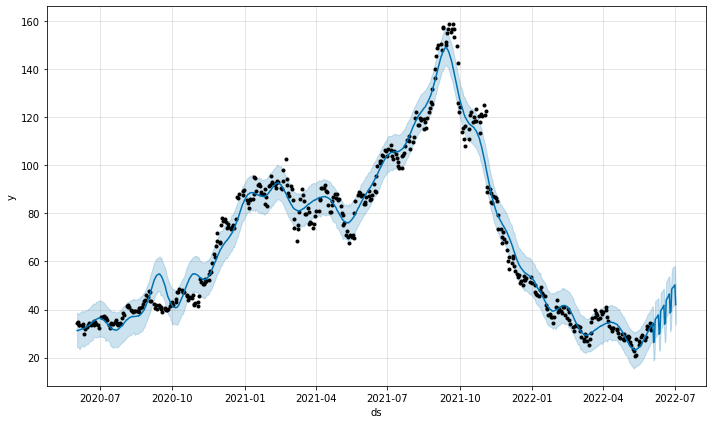

In [69]:
figure=m.plot(forecast, xlabel='ds', ylabel='y')

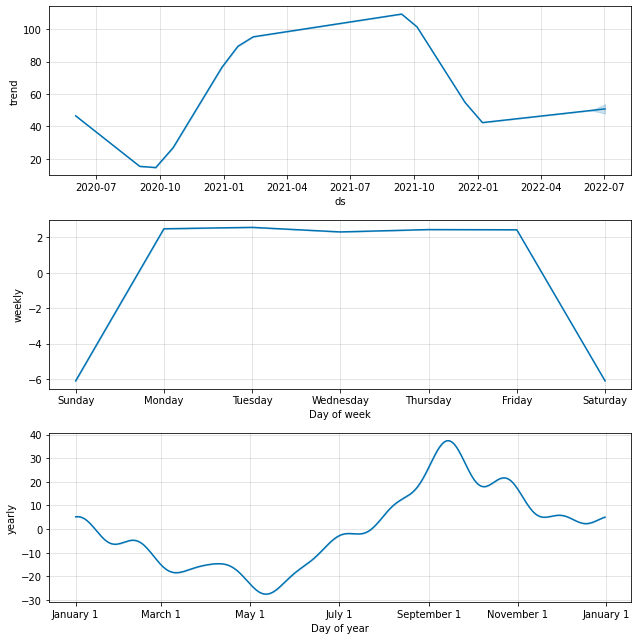

In [70]:
figure2=m.plot_components(forecast)

##Downloading the Forecast data

In [54]:
from google.colab import files
forecast.to_csv(f'{stock}_forecast.csv')
files.download(f'{stock}_forecast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>